In [159]:
import os
import glob
import json

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans


In [2]:
root_dir = './db'
object_dir = f'{root_dir}/objects'
media_dir = f'{root_dir}/media-info'

In [12]:
media_info = [json.load(open(os.path.join(media_dir, info))) for info in os.listdir(media_dir)]

print(f'A sample of media-info: \n{media_info[0]}')

A sample of media-info: 
{'author': '60 Giây Official', 'channel_id': 'UCRjzfa1E0gA50lvDQipbDMg', 'channel_url': 'https://www.youtube.com/channel/UCRjzfa1E0gA50lvDQipbDMg', 'description': '60 Giây Chiều - Ngày 24/10/2023 - HTV Tin Tức Mới Nhất\n► Đăng ký KÊNH để xem Tin Tức Mới Nhất: https://bit.ly/2HoUna4\nKênh Tin Tức Thời Sự 60 Giây Là Kênh Tổng Hợp Tin Tức - Sự Kiện - Giải trí Nhanh Nhất Việt Nam.\n------------\nXem TV online tại Truyền hình HTVC:\n✅ Web / Wap mobile :\n► https://hplus.com.vn\n► https://htvc.com.vn/\n► https://htvc.tv/\n✅ App mobile/TV HTVC :\n► IOS: https://goo.gl/Dih3DB\n► Android: https://goo.gl/XGBzxg\n► Smart TV /STB : Tải HTVC for Android TV\n.\n✅ Theo dõi HTVC trên Mạng xã hội :\n- Facebook Show : https://www.facebook.com/HPlusOfficial\n- Instagram Show : https://www.instagram.com/htvc_truyen_hinh_internet/\n- Lotus Show : https://lotus.vn/w/profile/18444255300272761.htm\n- Tiktok News : https://www.tiktok.com/@htvc.tintuc\n- Tiktok Phim : https://www.tiktok

# Recommender system

These are recognized objects in each keyframes -> 1 video may contains many repeated objects. 

We cluster videos based on the number of recognized videos in each video. 

In [8]:
vid_names = os.listdir(object_dir)
vid_names[: 10]

['L06_V004',
 'L10_V016',
 'L04_V006',
 'L01_V003',
 'L01_V012',
 'L07_V022',
 'L03_V007',
 'L03_V001',
 'L01_V029',
 'L08_V019']

In [110]:
# Collect relevant information, including all detected objects within a video

video_dict = {
    'dir': [], 
    'objects': [],
    'objects_id': []
}

for names in tqdm(vid_names): 
    names_dir = os.path.join(object_dir, names)

    for idx in os.listdir(names_dir): 
        vid_idx = os.path.join(names_dir, idx)
        video_dict['dir'].append(names_dir)
        json_obj = json.load(open(vid_idx))
        video_dict['objects'].append(json_obj['detection_class_entities'])
        video_dict['objects_id'].append(json_obj['detection_class_labels'])

100%|██████████| 363/363 [00:13<00:00, 26.38it/s]


In [39]:
object_counts = {} 
object_labels = {}

for objs, labels in zip(video_dict['objects'], video_dict['objects_id']): 
    for obj, label in zip(objs, labels): 
        if obj in object_counts: 
            object_counts[obj] += 1
        else: 
            object_counts[obj] = 0

        # Assuming there are no faults during annotating
        object_labels[obj] = label

In [67]:
print(len(object_labels))
print(f'Objects: {object_labels.keys()}')
# print(object_labels)

580
Objects: dict_keys(['Human face', 'Clothing', 'Woman', 'Girl', 'Poster', 'Person', 'Human hair', 'Dress', 'Office supplies', 'Billboard', 'Man', 'Human head', 'Flag', 'Human arm', 'Food', 'Television', 'Human hand', 'Whiteboard', 'Human eye', 'Human nose', 'Fast food', 'Picture frame', 'Human body', 'Human mouth', 'Book', 'Baked goods', 'Mammal', 'Computer monitor', 'Doll', 'Snack', 'Toy', 'Envelope', 'Box', 'House', 'Tree', 'Plant', 'Flowerpot', 'Porch', 'Houseplant', 'Building', 'Window', 'Table', 'Tent', 'Furniture', 'Kitchen appliance', 'Glasses', 'Goggles', 'Sunglasses', 'Human ear', 'Chair', 'Boy', 'Couch', 'Vehicle', 'Suit', 'Boat', 'Footwear', 'Jeans', 'Skyscraper', 'Watercraft', 'Shirt', 'Land vehicle', 'Car', 'Jacket', 'Elephant', 'Sculpture', 'Airplane', 'Aircraft', 'Sports equipment', 'Skateboard', 'Fashion accessory', 'Hiking equipment', 'Motorcycle', 'Helicopter', 'Human leg', 'Auto part', 'Helmet', 'Wheel', 'Handgun', 'Drill', 'Bottle', 'Guitar', 'Weapon', 'Musical i

In [105]:
label2idx = {k: v for v, k in enumerate(sorted(list(object_labels.keys())))}
label2idx

{'Accordion': 0,
 'Adhesive tape': 1,
 'Aircraft': 2,
 'Airplane': 3,
 'Alarm clock': 4,
 'Alpaca': 5,
 'Ambulance': 6,
 'Animal': 7,
 'Ant': 8,
 'Antelope': 9,
 'Apple': 10,
 'Armadillo': 11,
 'Artichoke': 12,
 'Asparagus': 13,
 'Auto part': 14,
 'Axe': 15,
 'Backpack': 16,
 'Bagel': 17,
 'Baked goods': 18,
 'Ball': 19,
 'Balloon': 20,
 'Banana': 21,
 'Banjo': 22,
 'Barge': 23,
 'Barrel': 24,
 'Baseball bat': 25,
 'Baseball glove': 26,
 'Bat': 27,
 'Bathroom accessory': 28,
 'Bathroom cabinet': 29,
 'Bathtub': 30,
 'Beaker': 31,
 'Bear': 32,
 'Bed': 33,
 'Bee': 34,
 'Beehive': 35,
 'Beer': 36,
 'Beetle': 37,
 'Bell pepper': 38,
 'Belt': 39,
 'Bench': 40,
 'Bicycle': 41,
 'Bicycle helmet': 42,
 'Bicycle wheel': 43,
 'Bidet': 44,
 'Billboard': 45,
 'Billiard table': 46,
 'Binoculars': 47,
 'Bird': 48,
 'Blender': 49,
 'Blue jay': 50,
 'Boat': 51,
 'Book': 52,
 'Bookcase': 53,
 'Boot': 54,
 'Bottle': 55,
 'Bottle opener': 56,
 'Bow and arrow': 57,
 'Bowl': 58,
 'Bowling equipment': 59,
 

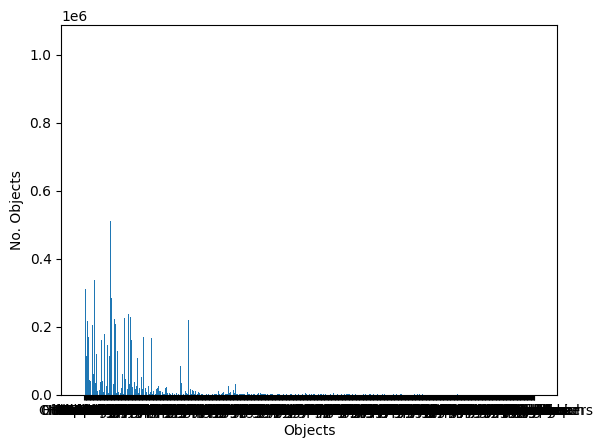

In [46]:
keys = list(object_counts.keys())
values = list(object_counts.values())

plt.bar(range(len(keys)), values)
plt.xticks(range(len(keys)), keys)
plt.xlabel("Objects")
plt.ylabel("No. Objects")
plt.show()

In [74]:
top_n = 20
top_counts = list(np.max(object_counts.values()))[: top_n]
total_counts = np.sum(list(object_counts.values()))
top_objects = []
for count in top_counts: 
    for key, value in object_counts.items(): 
        if value == count: 
            top_objects.append(key)
            continue

for key, val in zip(top_objects, top_counts):
    print(f'Objects: {key} - Awareness ratio: {val/total_counts}') 

Objects: Human face - Awareness ratio: 0.027606320695944576
Objects: Clothing - Awareness ratio: 0.09717816691561147
Objects: Woman - Awareness ratio: 0.029084696274835058
Objects: Girl - Awareness ratio: 0.010742781226309587
Objects: Poster - Awareness ratio: 0.02028387212994168
Objects: Person - Awareness ratio: 0.09125837843112235
Objects: Human hair - Awareness ratio: 0.015936845581667657
Objects: Dress - Awareness ratio: 0.004066682178804915
Objects: Office supplies - Awareness ratio: 0.003667557363637046
Objects: Billboard - Awareness ratio: 0.0064087023095572284
Objects: Man - Awareness ratio: 0.056686982563856216
Objects: Human head - Awareness ratio: 0.019321806813831822
Objects: Flag - Awareness ratio: 0.005608200917217723
Objects: Human arm - Awareness ratio: 0.03163913262127615
Objects: Food - Awareness ratio: 0.006799289193794144
Objects: Television - Awareness ratio: 0.0032044449781954377
Objects: Human hand - Awareness ratio: 0.011306847608253458
Objects: Whiteboard - Aw

In [89]:
video_dict

{'dir': ['./db/objects/L06_V004',
  './db/objects/L10_V016',
  './db/objects/L04_V006',
  './db/objects/L01_V003',
  './db/objects/L01_V012',
  './db/objects/L07_V022',
  './db/objects/L03_V007',
  './db/objects/L03_V001',
  './db/objects/L01_V029',
  './db/objects/L08_V019',
  './db/objects/L01_V011',
  './db/objects/L05_V025',
  './db/objects/L02_V009',
  './db/objects/L10_V014',
  './db/objects/L10_V018',
  './db/objects/L03_V022',
  './db/objects/L09_V028',
  './db/objects/L12_V017',
  './db/objects/L05_V003',
  './db/objects/L06_V010',
  './db/objects/L03_V019',
  './db/objects/L02_V017',
  './db/objects/L09_V019',
  './db/objects/L05_V005',
  './db/objects/L06_V027',
  './db/objects/L05_V013',
  './db/objects/L10_V023',
  './db/objects/L01_V015',
  './db/objects/L03_V016',
  './db/objects/L11_V018',
  './db/objects/L08_V022',
  './db/objects/L02_V030',
  './db/objects/L08_V029',
  './db/objects/L09_V004',
  './db/objects/L08_V026',
  './db/objects/L07_V028',
  './db/objects/L07_V

In [121]:
"""
Count every objects in a video by add every objects in detected objects with the same video name
"""
from copy import deepcopy

video_pd = pd.DataFrame(video_dict)
video_dir = list(set(video_dict['dir']))
labels = list(label2idx.keys())

In [143]:
len(video_pd)

106589

In [150]:
video_pd[video_pd.dir == video_dir[0]]

dir  \
40825  ./db/objects/L08_V015   
40826  ./db/objects/L08_V015   
40827  ./db/objects/L08_V015   
40828  ./db/objects/L08_V015   
40829  ./db/objects/L08_V015   
...                      ...   
41094  ./db/objects/L08_V015   
41095  ./db/objects/L08_V015   
41096  ./db/objects/L08_V015   
41097  ./db/objects/L08_V015   
41098  ./db/objects/L08_V015   

                                                 objects  \
40825  [House, Window, Window, Window, Window, Window...   
40826  [Clothing, Human face, Woman, Clothing, Man, H...   
40827  [Human face, Glasses, Suit, Man, Tie, Window, ...   
40828  [Woman, Clothing, Human face, Clothing, Table,...   
40829  [Traffic sign, Tree, Tree, Tree, House, Tree, ...   
...                                                  ...   
41094  [Land vehicle, Fountain, Vehicle, Building, Bu...   
41095  [Clothing, Person, Clothing, Shirt, Person, Ma...   
41096  [Human face, Poster, Dress, Clothing, Girl, Wo...   
41097  [Human face, Man, Human face, Man, Suit, Man, ...   
41098  [Building, Door, Door, Door, House, Door, Wind...   

                                              objects_id  
40825  [241, 485, 485, 485, 485, 485, 485, 485, 485, ...  
40826  [433, 502, 228, 433, 308, 502, 308, 433, 69, 5...  
40827  [502, 567, 120, 308, 105, 485, 485, 485, 69, 2...  
40828  [228, 433, 502, 433, 281, 333, 433, 502, 228, ...  
40829  [96, 391, 391, 391, 241, 391, 391, 391, 391, 3...  
...                                                  ...  
41094  [103, 131, 404, 462, 462, 218, 43, 404, 87, 46...  
41095  [433, 69, 433, 98, 69, 308, 573, 277, 573, 69,...  
41096  [502, 99, 58, 433, 333, 228, 69, 87, 502, 381,...  
41097  [502, 308, 502, 308, 120, 308, 120, 433, 228, ...  
41098  [462, 160, 160, 160, 241, 160, 485, 462, 160, ...  

[274 rows x 3 columns]

In [140]:
dirs_arr = []
labels_arr = []
for dir in tqdm(video_dir): 
    dirs_arr.append(dir)
    dir_df = video_pd[video_pd['dir'] == dir]

    # Create an array to count the number of existing objects in that dir
    label_arr = [0]*len(labels)

    # Go to every frames with the video name
    for object in dir_df['objects']: 
        for obj in objs: 
            label_idx = labels.index(obj) 
            label_arr[label_idx] += 1
    
    # Add results to the array that holds the results of counting objects
    labels_arr.append(label_arr)

In [151]:
# Create a null row
info_pd = pd.DataFrame(columns=['Video name', *list(label2idx.keys())])

# Update row

for idx in tqdm(range(len(dirs_arr))): 
    row = [dirs_arr[idx], *labels_arr[idx]]
    info_pd.loc[len(info_pd.index)] = row

100%|██████████| 363/363 [00:25<00:00, 14.29it/s]


In [152]:
info_pd.head()

Video name  Accordion  Adhesive tape  Aircraft  Airplane  \
0  ./db/objects/L08_V015          0              0         0         0   
1  ./db/objects/L10_V029          0              0         0         0   
2  ./db/objects/L03_V018          0              0         0         0   
3  ./db/objects/L09_V025          0              0         0         0   
4  ./db/objects/L06_V008          0              0         0         0   

   Alarm clock  Alpaca  Ambulance  Animal  Ant  ...  Wine rack  Winter melon  \
0            0       0          0       0    0  ...          0             0   
1            0       0          0       0    0  ...          0             0   
2            0       0          0       0    0  ...          0             0   
3            0       0          0       0    0  ...          0             0   
4            0       0          0       0    0  ...          0             0   

   Wok  Woman  Wood-burning stove  Woodpecker  Worm  Wrench  Zebra  Zucchini  
0    0      0                   0           0     0       0      0         0  
1    0      0                   0           0     0       0      0         0  
2    0      0                   0           0     0       0      0         0  
3    0      0                   0           0     0       0      0         0  
4    0      0                   0           0     0       0      0         0  

[5 rows x 581 columns]

In [158]:
temp_info = deepcopy(info_pd)
temp_info.head()

Video name  Accordion  Adhesive tape  Aircraft  Airplane  \
0  ./db/objects/L08_V015          0              0         0         0   
1  ./db/objects/L10_V029          0              0         0         0   
2  ./db/objects/L03_V018          0              0         0         0   
3  ./db/objects/L09_V025          0              0         0         0   
4  ./db/objects/L06_V008          0              0         0         0   

   Alarm clock  Alpaca  Ambulance  Animal  Ant  ...  Wine rack  Winter melon  \
0            0       0          0       0    0  ...          0             0   
1            0       0          0       0    0  ...          0             0   
2            0       0          0       0    0  ...          0             0   
3            0       0          0       0    0  ...          0             0   
4            0       0          0       0    0  ...          0             0   

   Wok  Woman  Wood-burning stove  Woodpecker  Worm  Wrench  Zebra  Zucchini  
0    0      0                   0           0     0       0      0         0  
1    0      0                   0           0     0       0      0         0  
2    0      0                   0           0     0       0      0         0  
3    0      0                   0           0     0       0      0         0  
4    0      0                   0           0     0       0      0         0  

[5 rows x 581 columns]

In [164]:
scaler = StandardScaler()
data = temp_info.iloc[: , 1:]
data_scaled = scaler.fit_transform(data)

## KMeans

Text(0, 0.5, 'Inertia')

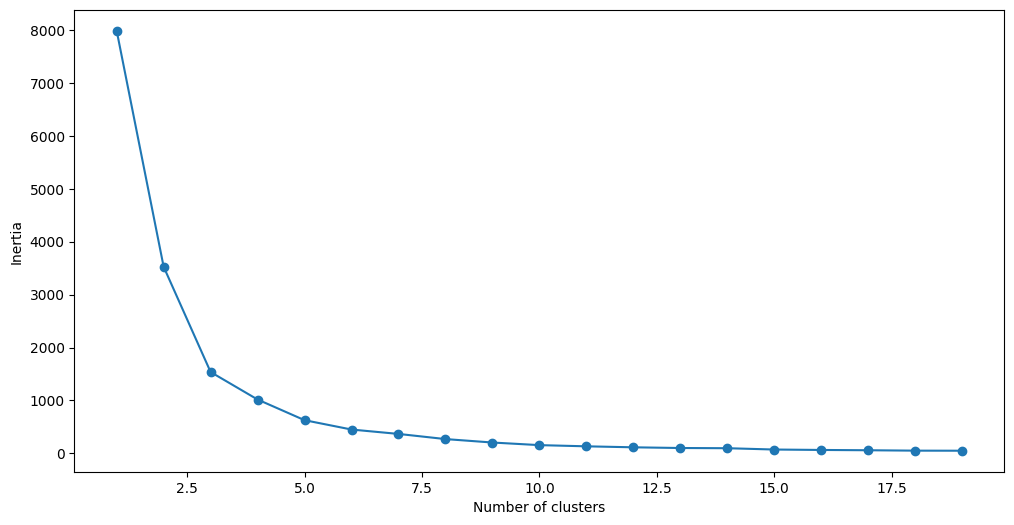

In [169]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Text(0, 0.5, 'Inertia')

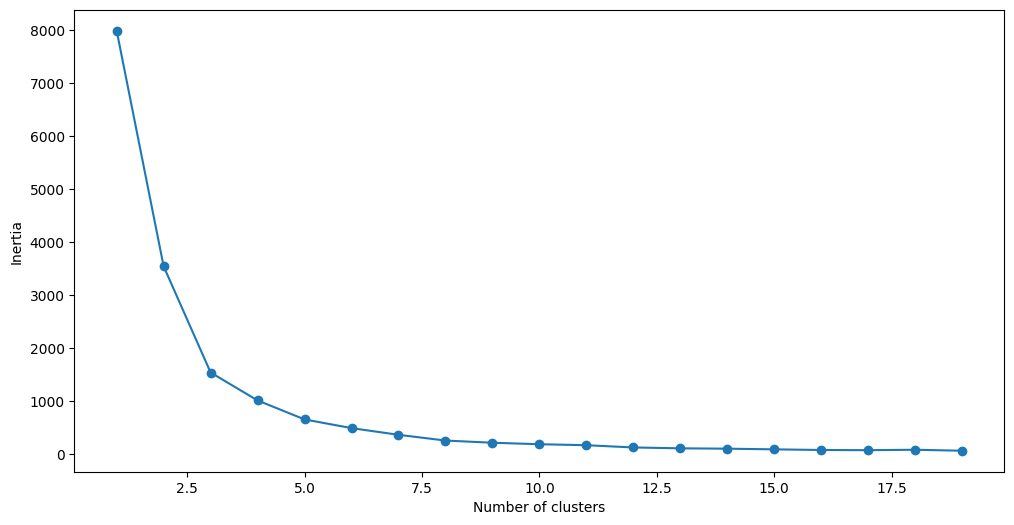

In [168]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='random')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Final Cluster

In [173]:
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, init='k-means++')
kmeans.fit(data_scaled)

KMeans(n_clusters=10)

In [175]:
temp_info['label'] = kmeans.labels_

# Recommend based on relevant data and random cluster

In [177]:
temp_info.head()

Video name  Accordion  Adhesive tape  Aircraft  Airplane  \
0  ./db/objects/L08_V015          0              0         0         0   
1  ./db/objects/L10_V029          0              0         0         0   
2  ./db/objects/L03_V018          0              0         0         0   
3  ./db/objects/L09_V025          0              0         0         0   
4  ./db/objects/L06_V008          0              0         0         0   

   Alarm clock  Alpaca  Ambulance  Animal  Ant  ...  Winter melon  Wok  Woman  \
0            0       0          0       0    0  ...             0    0      0   
1            0       0          0       0    0  ...             0    0      0   
2            0       0          0       0    0  ...             0    0      0   
3            0       0          0       0    0  ...             0    0      0   
4            0       0          0       0    0  ...             0    0      0   

   Wood-burning stove  Woodpecker  Worm  Wrench  Zebra  Zucchini  label  
0                   0           0     0       0      0         0      9  
1                   0           0     0       0      0         0      6  
2                   0           0     0       0      0         0      5  
3                   0           0     0       0      0         0      6  
4                   0           0     0       0      0         0      2  

[5 rows x 582 columns]

In [198]:
temp_info['Video name']

0      ./db/objects/L08_V015
1      ./db/objects/L10_V029
2      ./db/objects/L03_V018
3      ./db/objects/L09_V025
4      ./db/objects/L06_V008
               ...          
358    ./db/objects/L12_V019
359    ./db/objects/L05_V015
360    ./db/objects/L04_V009
361    ./db/objects/L06_V017
362    ./db/objects/L03_V019
Name: Video name, Length: 363, dtype: object

In [239]:
temp_info.to_csv('video_label.csv')

In [192]:
video_idx = 'L08_V015'

import re

pattern = re.escape(f"{video_idx}$")

In [234]:
row = temp_info[temp_info['Video name'].str.endswith(f"{video_idx}")]
selected_label = row.label.values[0]

# Picking from m remains clusters
m_clusters = 4
while True: 
    rand_clusters = np.random.choice(9, m_clusters, replace=False)
    if not np.isin(selected_label, rand_clusters): 
        break

rand_clusters

array([2, 3, 0, 1])

In [237]:
recommend_list = []

for cluster in rand_clusters: 
    selected_docs = temp_info[temp_info['label'] == cluster]
    n_docs = len(selected_docs)
    rand_idx = np.random.randint(0, n_docs, 3)
    for doc in selected_docs.iloc[rand_idx, 0]:   # Only select the first row as Video name
        recommend_idx = doc.split('/')[-1]
        recommend_list.append(recommend_idx)


In [238]:
recommend_list

['L11_V005',
 'L07_V031',
 'L03_V002',
 'L10_V003',
 'L10_V012',
 'L09_V020',
 'L05_V021',
 'L02_V020',
 'L01_V004',
 'L09_V015',
 'L10_V014',
 'L10_V007']

In [ ]:
def recommend_cold_start(df:pd.DataFrame, video_idx:str, m_clusters:int, m_videos:int=4) -> list[str]: 
    row = temp_info[temp_info['Video name'].str.endswith(f"{video_idx}")]
    selected_label = row.label.values[0]

    # Picking from m remains clusters
    while True: 
        rand_clusters = np.random.choice(9, m_clusters, replace=False)
        if not np.isin(selected_label, rand_clusters): 
            break

    
    recommend_list = []

    for cluster in rand_clusters: 
        selected_docs = temp_info[temp_info['label'] == cluster]
        n_docs = len(selected_docs)
        rand_idx = np.random.randint(0, n_docs, m_videos)
        for doc in selected_docs.iloc[rand_idx, 0]:   # Only select the first row as Video name
            recommend_idx = doc.split('/')[-1]
            recommend_list.append(recommend_idx)

    
    return recommend_list